In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import re
import time
import matplotlib.pyplot as plt

## Get Teams

In [3]:
url = "https://www.balldontlie.io/api/v1/teams"

r=requests.get(url)
r.status_code

200

In [4]:
data = r.json()
teams_df = pd.DataFrame(data['data'])
teams_df.to_csv("teams") # to view easily

## Get Players

In [3]:
players_url = "https://www.balldontlie.io/api/v1/players"
players_df = pd.DataFrame() # create an empty df
def get_page(number):
    param = {"page" : number, "per_page" : 100} # define params based off of page number
    r=requests.get(players_url, params = param)
    # if the status is successful, we want to gather and clean the data
    if r.status_code == 200:
        # gather data
        data = r.json()
        df = pd.DataFrame(data['data'])
        # clean to extract data from within inner dictionary
        df['team_id'] = df['team'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
        df['team_abr'] = df['team'].apply(lambda x: x.get('abbreviation') if isinstance(x, dict) else None)
        df['city'] = df['team'].apply(lambda x: x.get('city') if isinstance(x, dict) else None)
        df = df.drop('team', axis=1)
        # now we want to save to a df
        players_df = players_df.concat(df, ignore_index = True)
    # if the status gives an error, we would like to know what the error is
    else: 
        return print(f'Status code error: {r.status_code}')

In [7]:
# create all dfs using the function defined above
for i in range(0, 51):
    get_page(i)

In [8]:
players_df = pd.concat(dfs_list, ignore_index=True)
players_df.to_csv("players") # to be able to read it easily haha

## Get Games from 2022 Season 

In [9]:
games_url = "https://www.balldontlie.io/api/v1/games"
r = requests.get(games_url)
r.status_code

200

In [10]:
games_url = "https://www.balldontlie.io/api/v1/games"
games_df = pd.DataFrame() # initialize empty data frame
def get_page_game(number):
    para = {"page" : number , "per_page" : 100, "seasons[]" : [2022]} # set parameters according to page number
    r = requests.get(games_url, params = para)
    r.status_code
    data = r.json()
    df = pd.DataFrame(data['data'])
    # clean to extract data from within inner dictionary
    df['home_team_id'] = df['home_team'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
    df['visitor_team_id'] = df['visitor_team'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
    df = df.drop(['home_team', 'visitor_team'], axis=1)
    # concat to the DataFrame
    games_df = games_df.concat(df, ignore_index = True))
for i in range(0, 15):
    get_page_game(i)

In [11]:
games_df = pd.concat(games_list, ignore_index=True)
games_df.to_csv("games")

In [12]:
games_df.head()

,id,date,home_team_score,period,postseason,season,status,time,visitor_team_score,home_team_id,visitor_team_id
0,857369,2022-10-20T00:00:00.000Z,97,4,False,2022,Final,Final,103,14,13
1,857370,2022-10-20T00:00:00.000Z,88,4,False,2022,Final,Final,90,23,17
2,857381,2022-10-21T00:00:00.000Z,113,5,False,2022,Final,Final,111,25,24
3,857374,2022-10-21T00:00:00.000Z,102,4,False,2022,Final,Final,100,30,5
4,857376,2022-10-21T00:00:00.000Z,122,4,False,2022,Final,Final,129,11,15


## Get game and player stats

In [13]:
# put all game ids in a list
game_ids = games_df['id']
game_ids = game_ids.values.tolist()

stats_url = "https://www.balldontlie.io/api/v1/stats"
def get_game_stats(gameid):
    para = {"game_ids[]" : gameid}
    r = requests.get(stats_url, params = para)
    data = r.json()
    game_df = pd.DataFrame(data['data'])
    game_df['game_id'] = game_df['game'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
    game_df['player_id'] = game_df['player'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
    game_df['team_id'] = game_df['team'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
    game_df = game_df.drop(['game', 'player', 'team'], axis = 1)
    return game_df

# batch_size = 10  # Adjust this value based on your needs

# # Process game_ids in batches
# all_game_stats = pd.DataFrame()
# for i in range(0, len(game_ids), batch_size):
#     batch_game_ids = game_ids[i:i + batch_size]
#     batch_stats = get_game_stats(batch_game_ids)
#     all_game_stats = pd.concat([all_game_stats, batch_stats], ignore_index=True)

# print(all_game_stats.shape)



method 1: Create Batches

In [ ]:
batch_size = 20

all_batches = []

for i in range(0, len(game_ids), batch_size):
    batch = game_ids[i:i + batch_size]
    all_batches.append(batch)


In [ ]:
all_game_stats = pd.DataFrame()
for batch in all_batches:
    game_stat = get_game_stats(id)
    all_game_stats = pd.concat([all_game_stats, game_stat], ignore_index = True)

    time.sleep(10)


In [ ]:
all_game_stats.to_csv("allgamestats")

method 2: use time.sleep between each game pull

In [29]:
all_stats = pd.DataFrame()

In [30]:
for id in game_ids:
    game_stat = get_game_stats(id)
    all_stats = pd.concat([all_stats, game_stat], ignore_index=True)
    time.sleep(1)

In [32]:
all_stats.to_csv("all_game_stats.csv", index = False)

## Distribution of Points 

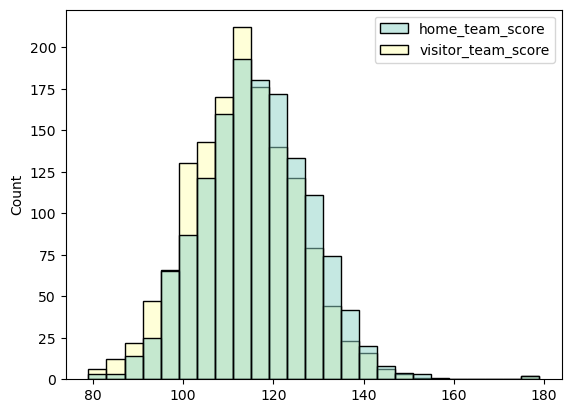

In [ ]:
sns.histplot([games_df['home_team_score'],games_df['visitor_team_score']], binwidth = 4, palette="Set3" )
plt.savefig("scores_distribution.png")